# Shuttling and noise

Our question: take two circuits that only differ because of crossings, for example see the two below, imported from file.  Is the one that doesn't present any crossings any better in terms mitigating noise?

## Importing the circuits

In [1]:
from pathlib import Path

# path to wherever Jupyter is launched from
project_root = Path.cwd()  

# now build a path to .qasm files
qasm_dir   = project_root
qasm_file_paths = sorted(qasm_dir.glob("*.qasm"))


if not qasm_file_paths:
    raise FileNotFoundError(f"No .qasm files found in {qasm_dir}")

In [2]:
from bloqade import qasm2
from bloqade.qasm2.parse.lowering import QASM2
from bloqade.qasm2.passes import QASM2Py

# parse & lower each one
programs = {}
for path in qasm_file_paths:
    prog = QASM2(qasm2.main).loadfile(file=path)

    """
    reinterpret into Bloqade's parallelization-friendly intermediate representation. 
    Similar behaviour could have been obtained by just using qasm2.extended above
    """
    QASM2Py(prog.dialects)(prog)
    prog = prog.similar(qasm2.extended)

    programs[Path(path).stem] = prog
    print(f"→ {path} parsed & lowered: {prog}")

# `programs` now holds each file’s lowered IR under its filename-stem.


→ /home/alessandro/Desktop/qhack/tutorial/ver1.qasm parsed & lowered: Method("ver1")
→ /home/alessandro/Desktop/qhack/tutorial/ver2.qasm parsed & lowered: Method("ver2")


In [3]:
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

target = QASM2(allow_parallel=True)

In [4]:
program1 = target.emit(programs["ver1"])
pprint(program1)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[4];
h var_0[0];
h var_0[2];
CX var_0[0], var_0[1];
CX var_0[2], var_0[3];


In [5]:
program2 = target.emit(programs["ver1"])
pprint(program2)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[4];
h var_0[0];
h var_0[2];
CX var_0[0], var_0[1];
CX var_0[2], var_0[3];


## Draw the circuits

In [6]:
from kirin import ir
from qiskit import QuantumCircuit

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold


@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass


# helper to go from Method → Qiskit
def method_to_qiskit(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # run extended pass in case forgot
    extended_opt.run_pass(method, parallelize=parallelize)
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

def method_to_qiskit_noparallel(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

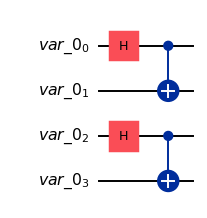

In [7]:
circuit1 = programs["ver1"]

qc = method_to_qiskit_noparallel(circuit1)
#print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=0.7)
display(fig)   # in a Jupyter notebook

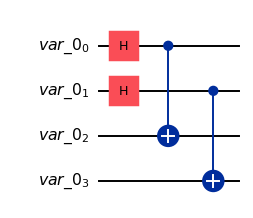

In [8]:
circuit2 = programs["ver2"]

qc = method_to_qiskit_noparallel(circuit2)
#print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=0.7)
display(fig)   # in a Jupyter notebook

## Simulate without noise

In [9]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk

In [10]:
def method1(parallelize: bool = False):

    @extended_opt(parallelize=parallelize)
    def method1_program():
        qreg = qasm2.qreg(4)
        qasm2.h(qreg[0])
        qasm2.h(qreg[2])
        qasm2.cx(qreg[0],qreg[1])
        qasm2.cx(qreg[2],qreg[3])
        qasm2.cx(qreg[0],qreg[1])
        qasm2.cx(qreg[2],qreg[3])
        return qreg

    return method1_program


kernel1 = method1(parallelize=False)

In [19]:
from bloqade.pyqrack import PyQrack
from collections import Counter
from qiskit.quantum_info import Statevector, Operator

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
reg = device.run(kernel1)

qbit = reg[0]
finalstate1 = Statevector(qbit.sim_reg.out_ket())
display(finalstate1.draw("latex"))

<IPython.core.display.Latex object>

In [20]:
def method2(parallelize: bool = False):

    @extended_opt(parallelize=parallelize)
    def method2_program():
        qreg = qasm2.qreg(4)
        qasm2.h(qreg[0])
        qasm2.h(qreg[1])
        qasm2.cx(qreg[0],qreg[2])
        qasm2.cx(qreg[1],qreg[3])
        qasm2.cx(qreg[0],qreg[1])
        qasm2.cx(qreg[2],qreg[3])
        return qreg

    return method2_program


kernel2 = method2(parallelize=False)

In [21]:
from bloqade.pyqrack import PyQrack
from collections import Counter
from qiskit.quantum_info import Statevector, Operator

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
reg = device.run(kernel2)

qbit = reg[0]
finalstate2 = Statevector(qbit.sim_reg.out_ket())
display(finalstate2.draw("latex"))

<IPython.core.display.Latex object>

The states are the same save for global phases and renaming the qbits

## Now let's add noise

In [23]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
import numpy as np

# add noise
noise_kernel1 = kernel1.similar()
extended_opt.run_pass(noise_kernel1, parallelize=True)
NoisePass(extended_opt)(noise_kernel1)

noise_kernel1 = noise_kernel1.similar(extended_opt.add(native))

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
Nshots = 10000

noisy_states1 = [reg[0].sim_reg.out_ket() for reg in device.multi_run(noise_kernel1, _shots = Nshots)]

fidelities = [np.abs(np.vdot(noisy_states1[i],finalstate1))**2 for i in range(Nshots)]
fidelity1 = np.mean(fidelities)
sfidelity1 = np.std(fidelities)

print(f"{fidelity1} +- {np.sqrt(fidelity1/Nshots)}")

0.9090995812441061 +- 0.009534671369502496


In [24]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
import numpy as np

# add noise
noise_kernel2 = kernel2.similar()
extended_opt.run_pass(noise_kernel2, parallelize=True)
NoisePass(extended_opt)(noise_kernel2)

noise_kernel2 = noise_kernel2.similar(extended_opt.add(native))

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
Nshots = 10000

noisy_states2 = [reg[0].sim_reg.out_ket() for reg in device.multi_run(noise_kernel2, _shots = Nshots)]

fidelities = [np.abs(np.vdot(noisy_states1[i],finalstate1))**2 for i in range(Nshots)]
fidelity2 = np.mean(fidelities)
sfidelity2 = np.std(fidelities)

print(f"{fidelity2} +- {np.sqrt(fidelity2/Nshots)}")

0.9090995812441061 +- 0.009534671369502496


# Let's parallelize (naively)

## Simulate without noise

In [25]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk

In [26]:
def method1(parallelize: bool = False):

    @extended_opt(parallelize=parallelize)
    def method1_program():
        qreg = qasm2.qreg(4)
        qasm2.h(qreg[0])
        qasm2.h(qreg[2])
        qasm2.cx(qreg[0],qreg[1])
        qasm2.cx(qreg[2],qreg[3])
        qasm2.cx(qreg[0],qreg[1])
        qasm2.cx(qreg[2],qreg[3])
        return qreg

    return method1_program


kernel1 = method1(parallelize=True)

In [27]:
qasm2.parse.pprint(target.emit(method1(parallelize=True)))

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg qreg[4];
parallel.U(1.5707963267949, 0.0, 3.14159265358979) {
  qreg[0];
  qreg[2];
}
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  qreg[1];
  qreg[3];
}
parallel.CZ {
  qreg[0], qreg[1];
  qreg[2], qreg[3];
}
parallel.U(1.5707963267949, 3.14159265358979, 3.14159265358979) {
  qreg[1];
  qreg[3];
}
parallel.U(0.0, 0.0, 3.14159265358979) {
  qreg[0];
  qreg[2];
}
parallel.U(0.0, 0.0, 6.28318530717958) {
  qreg[1];
  qreg[3];
}
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  qreg[1];
  qreg[3];
}
parallel.CZ {
  qreg[0], qreg[1];
  qreg[2], qreg[3];
}
parallel.U(1.5707963267949, 3.14159265358979, 3.14159265358979) {
  qreg[1];
  qreg[3];
}
parallel.U(0.0, 0.0, 3.14159265358979) {
  qreg[0];
  qreg[2];
}
parallel.U(0.0, 0.0, 6.28318530717958) {
  qreg[1];
  qreg[3];
}


In [28]:
from bloqade.pyqrack import PyQrack
from collections import Counter
from qiskit.quantum_info import Statevector, Operator

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
reg = device.run(kernel1)

qbit = reg[0]
finalstate1 = qbit.sim_reg.out_ket()
display(Statevector(finalstate1).draw("latex"))

<IPython.core.display.Latex object>

In [29]:
def method2(parallelize: bool = False):

    @extended_opt(parallelize=parallelize)
    def method2_program():
        qreg = qasm2.qreg(4)
        qasm2.h(qreg[0])
        qasm2.h(qreg[1])
        qasm2.cx(qreg[0],qreg[2])
        qasm2.cx(qreg[1],qreg[3])
        qasm2.cx(qreg[0],qreg[1])
        qasm2.cx(qreg[2],qreg[3])
        return qreg

    return method2_program


kernel2 = method2(parallelize=True)

In [30]:
qasm2.parse.pprint(target.emit(method2(parallelize=True)))

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg qreg[4];
parallel.U(1.5707963267949, 0.0, 3.14159265358979) {
  qreg[0];
  qreg[1];
}
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  qreg[2];
  qreg[3];
}
parallel.CZ {
  qreg[0], qreg[2];
  qreg[1], qreg[3];
}
parallel.U(1.5707963267949, 3.14159265358979, 3.14159265358979) {
  qreg[2];
  qreg[3];
}
parallel.U(0.0, 0.0, 3.14159265358979) {
  qreg[0];
  qreg[1];
}
parallel.U(0.0, 0.0, 6.28318530717958) {
  qreg[2];
  qreg[3];
}
U(1.5707963267949, 0.0, 6.28318530717959) qreg[1];
cz qreg[0], qreg[1];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) qreg[1];
U(0.0, 0.0, 3.14159265358979) qreg[0];
U(0.0, 0.0, 6.28318530717958) qreg[1];
U(1.5707963267949, 0.0, 6.28318530717959) qreg[3];
cz qreg[2], qreg[3];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) qreg[3];
U(0.0, 0.0, 3.14159265358979) qreg[2];
U(0.0, 0.0, 6.28318530717958

In [31]:
from bloqade.pyqrack import PyQrack
from collections import Counter
from qiskit.quantum_info import Statevector, Operator

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
reg = device.run(kernel2)

qbit = reg[0]
finalstate2 = qbit.sim_reg.out_ket()
display(Statevector(finalstate2).draw("latex"))

<IPython.core.display.Latex object>

Good: the states are the same save for global phases and renaming the qbits

## Now let's add noise

In [32]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
import numpy as np

# add noise
noise_kernel1 = kernel1.similar()
extended_opt.run_pass(noise_kernel1, parallelize=True)
NoisePass(extended_opt)(noise_kernel1)

noise_kernel1 = noise_kernel1.similar(extended_opt.add(native))

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
Nshots = 10000

noisy_states1 = [reg[0].sim_reg.out_ket() for reg in device.multi_run(noise_kernel1, _shots = Nshots)]

fidelities = [np.abs(np.vdot(noisy_states1[i],finalstate1))**2 for i in range(Nshots)]
fidelity1 = np.mean(fidelities)
sfidelity1 = np.std(fidelities)

print(f"{fidelity1} +- {np.sqrt(fidelity1/Nshots)}")

0.9120497364172823 +- 0.009550129509159979


In [33]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
import numpy as np

# add noise
noise_kernel2 = kernel2.similar()
extended_opt.run_pass(noise_kernel2, parallelize=True)
NoisePass(extended_opt)(noise_kernel2)

noise_kernel2 = noise_kernel2.similar(extended_opt.add(native))

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
Nshots = 10000

noisy_states2 = [reg[0].sim_reg.out_ket() for reg in device.multi_run(noise_kernel2, _shots = Nshots)]

fidelities = [np.abs(np.vdot(noisy_states2[i],finalstate2))**2 for i in range(Nshots)]
fidelity2 = np.mean(fidelities)
sfidelity2 = np.std(fidelities)

print(f"{fidelity2} +- {np.sqrt(fidelity2/Nshots)}")

0.903024472085213 +- 0.009502759978475796


We conclude that crossings are not relevant with this noise model